In [82]:
#Load packages
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt

In [84]:
# Param du modèle
Lx = 500
Lz = 3.40

In [86]:
# Discritization 
nlay = 100 #nombre de cellules 
nrow = 1
ncol = 100 #taille horizontal du domaine 

delr = Lx / ncol #x
delc = 1.0 #y
delv = Lz / nlay #la largeur de chaque cellule/z

henry_top= -69.97 #top elevation of model.
henry_botm = np.linspace(henry_top - delv, -73.37, nlay) #bottom elevation of model.

#qinflow = 100
#qinflow = 200
#qinflow = 300
#qinflow = 400
#qinflow = 500
qinflow = 500 #m3/day

#qinflow = 20000
#qinflow = 5000

dmcoef = 0.0000054 #m2/day diffusion coefficient could also try 1.62925 as another case of the Henry problem, showing rate of diffusion

In [88]:
# basic MODFLOW model structure
modelname = "henry"
swt = flopy.seawat.Seawat(modelname, exe_name="swtv4") #creation of seawat model 
print(swt.namefile)

henry.nam


In [90]:
ipakcb = 53 #save cell fluxes to unit 53

In [92]:
dis = flopy.modflow.ModflowDis(
    swt,
    nlay,
    nrow,
    ncol,
    nper=1,
    delr=delr,
    delc=delc,
    laycbd=0,
    top=henry_top,
    botm=henry_botm,
    perlen=1.5,
    nstp=15,
)

In [94]:
#Variables for the BAS package
#condition limite a gauche du domaine
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1 #boundary conditions, fixed(-1)/active(1). Fixed means constant water level.

[[[0.000209 0.000209 0.000209 ... 0.000209 0.000209 0.000209]]

 [[0.000209 0.000209 0.000209 ... 0.000209 0.000209 0.000209]]

 [[0.000209 0.000209 0.000209 ... 0.000209 0.000209 0.000209]]

 ...

 [[0.000144 0.000144 0.000144 ... 0.000144 0.000144 0.000144]]

 [[0.000144 0.000144 0.000144 ... 0.000144 0.000144 0.000144]]

 [[0.000144 0.000144 0.000144 ... 0.000144 0.000144 0.000144]]]


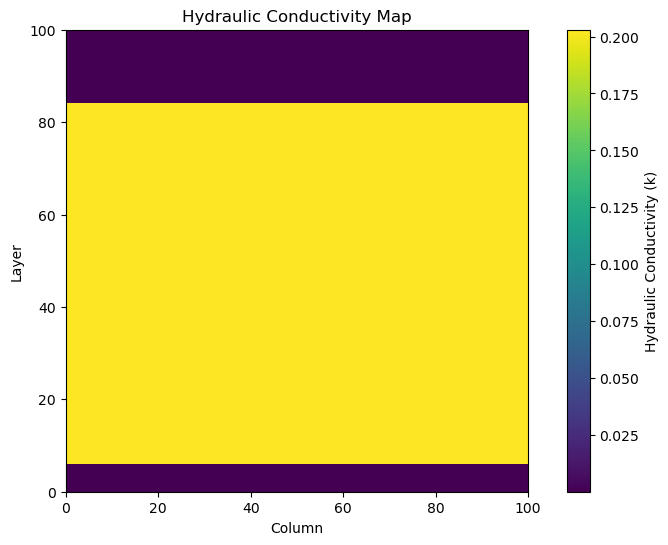

In [96]:
#Paramettre d'entré "Conductivité hydraulique (k)"
couche1=-70.22
couche2=-72.87
hk1 = 2.09e-04
hk2 = 2.03e-01
hk3 = 1.44e-04


lay_top=min(abs(henry_botm-couche1))
lay_bot=min (abs(henry_botm-couche2))

nlay_top=list(abs(henry_botm-couche1)).index(lay_top)

nlay_bot=list(abs(henry_botm-couche2)).index(lay_bot)

hk = np.ones((nlay, nrow, ncol), dtype=np.float64)
hk[:, :, :] = hk1
hk[nlay_top:nlay_bot, :, :] = hk2
hk[nlay_bot+1:nlay,:,:]=hk3

#Afficher la matrice
print(hk)

#Matrice sous fome d'image des conductivité hydraulique 
plt.figure(figsize=(10, 6))
plt.imshow(hk[:, 0, :], cmap='viridis', origin='lower', extent=[0, ncol, 0, nlay])
plt.colorbar(label='Hydraulic Conductivity (k)')
plt.title('Hydraulic Conductivity Map')
plt.xlabel('Column')
plt.ylabel('Layer')
plt.show()

In [98]:
# Add LPF package to the MODFLOW model with updated hk values
lpf = flopy.modflow.ModflowLpf(swt, hk=hk, vka=hk, ipakcb=ipakcb)

In [100]:
#Add BAS package to the MODFLOW model
bas = flopy.modflow.ModflowBas(swt, ibound, 0)

In [102]:
#Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(swt, hclose=1.0e-8)


In [104]:
#Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(
    swt,
    stress_period_data={(0, 0): ["save head", "save budget"]},
    compact=True,
)

In [106]:
#Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []

for k in range(nlay):
    wel_sp1.append([k, 0, 0, qinflow/nlay])
    ssm_sp1.append([k, 0, 0, 0.0, itype["WEL"]])
    ssm_sp1.append([k, 0, ncol - 1, 35.0, itype["BAS6"]])


wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

In [108]:
#porosité heterogene 

couche1=-70.22
couche2=-72.87

prsity_1 = 0.40  # Porosité de la couche 1
prsity_2 = 0.34 # Porosité de la couche 2
prsity_3 = 0.25  # Porosité de la couche 3

lay_top=min(abs(henry_botm-couche1))
lay_bot=min (abs(henry_botm-couche2))

nlay_top=list(abs(henry_botm-couche1)).index(lay_top)

nlay_bot=list(abs(henry_botm-couche2)).index(lay_bot)

prsity = np.ones((nlay, nrow, ncol), dtype=np.float64)
prsity[:, :, :] = prsity_1
prsity[nlay_top:nlay_bot, :, :] = prsity_2
prsity[nlay_bot+1:nlay,:,:]=prsity_3

#Afficher la matrice
print(prsity)

[[[0.4  0.4  0.4  ... 0.4  0.4  0.4 ]]

 [[0.4  0.4  0.4  ... 0.4  0.4  0.4 ]]

 [[0.4  0.4  0.4  ... 0.4  0.4  0.4 ]]

 ...

 [[0.25 0.25 0.25 ... 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 ... 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 ... 0.25 0.25 0.25]]]


In [110]:
#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs=-5,
    prsity=prsity,  #porosité
    sconc=35.0,   #concentration de sel 
    ifmtcn=0,
    chkmas=False,
    nprobs=10,
    nprmas=10,
    dt0=0.001,
)

adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0.0, trpt=1.0, trpv=1.0, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)


In [112]:
#Create the SEAWAT model structure
vdf = flopy.seawat.SeawatVdf(
    swt,
    iwtable=0,
    densemin=0,
    densemax=0,
    denseref=1000.0,
    #denseref=1,
    denseslp=0.7143,
    firstdt=1e-3,
)


In [114]:
#Write the input files
swt.write_input()

In [116]:
#Run the model
success, buff = swt.run_model(silent=True, report=True)

if not success:
    raise Exception("SEAWAT did not terminate normally.")

In [117]:
#post proc and plot
ucnobj = bf.UcnFile("MT3D001.UCN", model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])

cbbobj = bf.CellBudgetFile("henry.cbc")
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times[-1])[0]
qy = np.zeros((nlay, nrow, ncol), dtype=float)
qz = cbbobj.get_data(text="flow lower face", totim=times[-1])[0]

Text(0.5, 1.0, 'Simulated Concentrations')

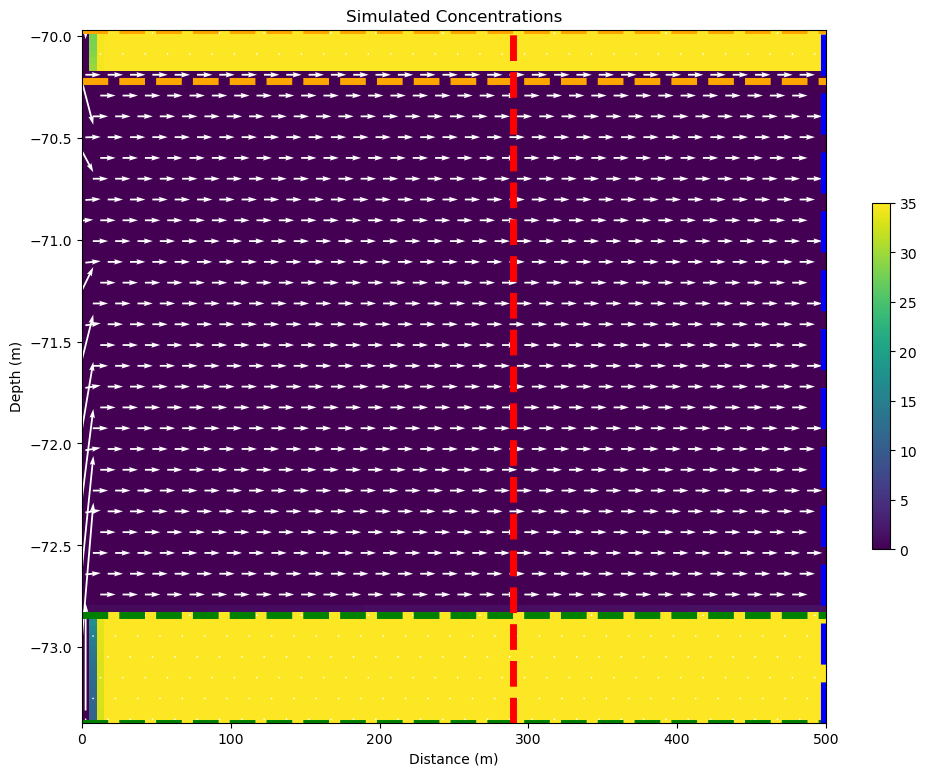

In [118]:
#Afficher le modele 2D 
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1, 1, 1)
pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax, line={"row": 0})
arr = pmv.plot_array(concentration)
pmv.plot_vector(qx, qy, -qz, color="white", kstep=3, hstep=3)

#Afficher les top et bottom pour chaque couches : 
ax.axhline(y=-69.97, color='orange', linestyle='--',linewidth=5,label='Top layer 1')
ax.axhline(y=-70.22, color='orange', linestyle='--',linewidth=5,label='Bottom layer 1 and Top layer 2')
ax.axhline(y=-72.84, color='green', linestyle='--',linewidth=5,label='Bottom layer 2 and Top layer 3')
ax.axhline(y=-73.37, color='green', linestyle='--',linewidth=5,label='Bottom layer 3')
#ax.legend()

#Afficher les etiquettes de k : 
#ax.text(580,-70.09, "k = 1.412863265", color='black', fontsize=14)
#ax.text(580, -71.53, "k = 1550.491407", color='black', fontsize=14)
#ax.text(580, -73.10, "k = 0.971649943", color='black', fontsize=14)

#Mettre la Mer et le puits sur le modele :
ax.axvline(x=289.96, color='red', linestyle='--',linewidth=5, label='Well Demmer 4')
ax.axvline(x=500, color='blue', linestyle='--',linewidth=8, label='Sea')

#ax.legend(loc='upper right', bbox_to_anchor=(2.1, 0.8), borderaxespad=0,prop={'size': 18})

plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")
ax.set_title("Simulated Concentrations")


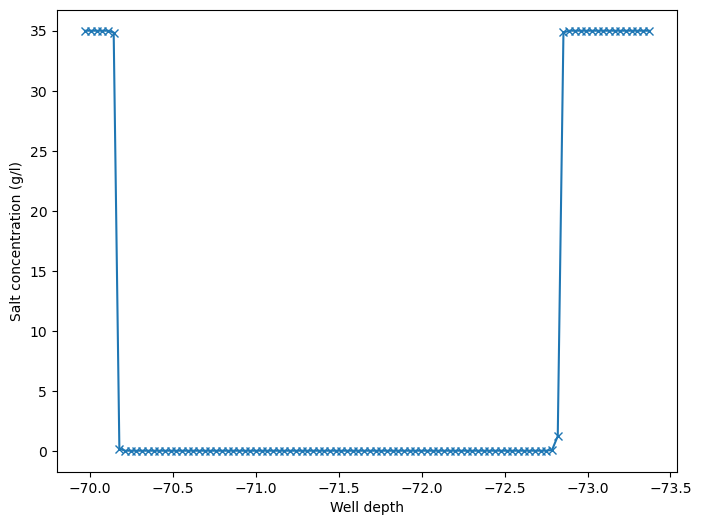

Minimum head: -2.8302471e-11
Maximum head: 488602.5
Mean head: 225148.19


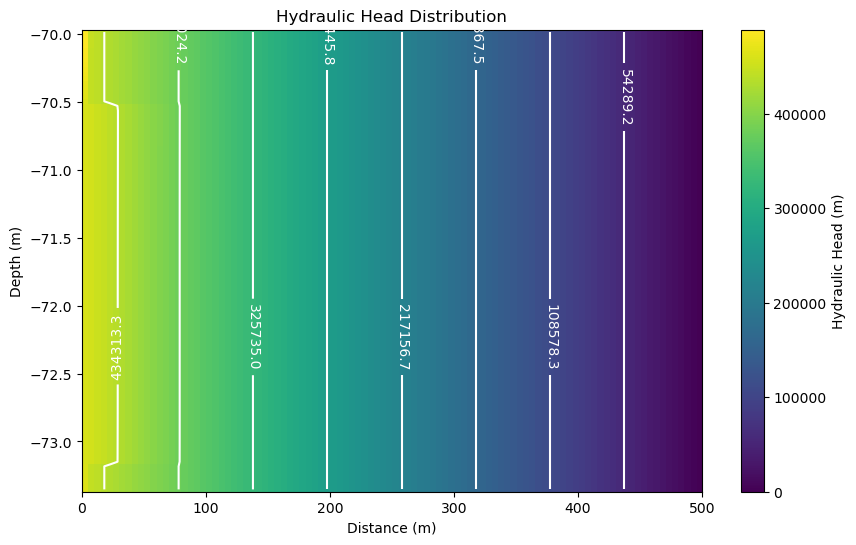

Profondeur du puits	Concentration de sel (ppt)
-69.97			35.0
-70.00			35.0
-70.04			35.0
-70.07			35.0
-70.11			34.99964904785156
-70.14			34.8505859375
-70.18			0.17440463602542877
-70.21			0.0003470778465270996
-70.24			4.796070811607933e-07
-70.28			4.677865206303977e-08
-70.31			3.8498221499594365e-08
-70.35			3.1606280259666164e-08
-70.38			2.56521790475972e-08
-70.42			2.055167414027892e-08
-70.45			1.622680301238688e-08
-70.49			1.259968751554652e-08
-70.52			9.597329153621104e-09
-70.55			7.148810876600464e-09
-70.59			5.186171936344408e-09
-70.62			3.6454828045151544e-09
-70.66			2.4655575359133763e-09
-70.69			1.5893036886538425e-09
-70.73			9.630769515212023e-10
-70.76			5.374459766116502e-10
-70.79			2.6707633327127667e-10
-70.83			1.1123243992550158e-10
-70.86			3.4009524363387555e-11
-70.90			4.659655473970847e-12
-70.93			5.620111038877329e-13
-70.97			1.828265620493208e-12
-71.00			4.434188259627714e-12
-71.03			8.979096112471385e-12
-71.07			1.61581373281372e-11
-71.10

In [119]:
#Afficher le graphe de concentration de sel le long du puits Demmer 4 
col_well = 57 #distance du puits 4 : 289.96M

profondeur_puits = 242.77  #M
indice_couche = np.abs(henry_botm - profondeur_puits).argmin() #Pour trouver l'indice de la couche la plus proche de la profondeur du puits 
concentration_well = concentration[:, indice_couche, col_well]
profondeur_puits_x = np.linspace(-69.97, -73.37, len(concentration_well))

plt.figure(figsize=(8, 6))
plt.plot(profondeur_puits_x, concentration_well, marker='x', linestyle='-')
plt.xlabel('Well depth')
plt.ylabel('Salt concentration (g/l)')
plt.gca().invert_xaxis() 
plt.show()

# Charger les résultats de la tete hydraulique
headobj = bf.HeadFile(f"{modelname}.hds")
head = headobj.get_data(totim=headobj.get_times()[-1])

print("Minimum head:", head.min())
print("Maximum head:", head.max())
print("Mean head:", head.mean())


# Créer la carte de tête hydraulique avec une échelle de couleurs ajustée
plt.figure(figsize=(10, 6))
plt.imshow(head[:, 0, :], cmap='viridis', origin='lower', extent=[0, Lx, henry_botm[-1], henry_top], vmin=0, vmax=head.max())
plt.colorbar(label='Hydraulic Head (m)')
plt.title('Hydraulic Head Distribution')
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.gca().set_aspect('auto')

# Tracer des contours
contour = plt.contour(head[:, 0, :], levels=np.linspace(head.min(), head.max(), 10), 
                      origin='lower', extent=[0, Lx, henry_botm[-1], henry_top], colors='white')
plt.clabel(contour, fmt='%1.1f', colors='white')

plt.show()

#Retirer les concentration du sel du graphique precedent sous forme d'un tableau 
print("Profondeur du puits\tConcentration de sel (ppt)")
for i in range(len(profondeur_puits_x)):
    print(f"{profondeur_puits_x[i]:.2f}\t\t\t{concentration_well[i]}")

